# Sentiment Analysis for Twitter Tweets
This project performs sentiment analysis by scraping tweets from Twitter and testing for polarity (positive, neutral, and negative) connotation for each Tweet of a query

In [4]:
import snscrape.modules.twitter as sntwitter
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
plt.style.use('fivethirtyeight')

## Scraping Tweets for Analysis
Alternatively we could use ‘Tweepy’ to scrape Tweets but this is limited to about 3,000 tweets and also requires an API authentication process.
However, we have the option to set a limit for the maximum amount of tweets that is scraped

In [7]:
query = "(from:elonmusk) until:2023-03-01 since:2023-01-01"
tweets = []
limit = 10000

for tweet in sntwitter.TwitterSearchScraper(query).get_items():
    #print(vars(tweet))
    #break 
    if len(tweets) == limit:
        break
    else:
        tweets.append([tweet.date, tweet.user.username, tweet.rawContent])

df = pd.DataFrame(tweets, columns=['Date','User','Tweet'])
#print(vars(tweet))
print(df)

                          Date      User  \
0    2023-02-28 22:42:25+00:00  elonmusk   
1    2023-02-28 22:36:16+00:00  elonmusk   
2    2023-02-28 21:23:19+00:00  elonmusk   
3    2023-02-28 21:10:51+00:00  elonmusk   
4    2023-02-28 19:54:53+00:00  elonmusk   
...                        ...       ...   
1280 2023-01-01 19:34:42+00:00  elonmusk   
1281 2023-01-01 19:33:38+00:00  elonmusk   
1282 2023-01-01 19:29:30+00:00  elonmusk   
1283 2023-01-01 19:26:19+00:00  elonmusk   
1284 2023-01-01 19:25:38+00:00  elonmusk   

                                                  Tweet  
0                                 @WSJ @WSJopinion Good  
1     Periodic reminder to try using Twitter Lists. ...  
2                                  @jamesdouma Accurate  
3                                  @Erdayastronaut Yeah  
4     @O42nl @kirillgroshkov Tesla does INT8 inferen...  
...                                                 ...  
1280                 @BriannaWu Thanks for paying me $8  
1281  @

 # Processing Scraped Tweets for Analysis
We need to clean the tweets to make it suitable for our models. We do this using the Python package (re)regular expression for filtering strings.
We remove ‘@‘ mentions from tweets, ‘#’ hashtags, and links ‘http’ from Tweets.

In [8]:
# Clean the tweets
def cleanTweet(text):
    text = re.sub(r'@[A-Za-z0-9_]+', '',text) # Removes @ Mentions
    text = re.sub(r'#','', text) # Removing the '#' symbol
    text = re.sub(r'RT[\s]+', '',text)
    text = re.sub(r'https?:\/\/\S+','',text)
    text = re.sub(r'_[A-Za-z0-9]+','',text)
    
    return text

In [9]:
df['Tweet'] = df['Tweet'].apply(cleanTweet)
df

,Date,User,Tweet
0,2023-02-28 22:42:25+00:00,elonmusk,Good
1,2023-02-28 22:36:16+00:00,elonmusk,Periodic reminder to try using Twitter Lists. ...
2,2023-02-28 21:23:19+00:00,elonmusk,Accurate
3,2023-02-28 21:10:51+00:00,elonmusk,Yeah
4,2023-02-28 19:54:53+00:00,elonmusk,Tesla does INT8 inference. Way more efficien...
...,...,...,...
1280,2023-01-01 19:34:42+00:00,elonmusk,Thanks for paying me $8
1281,2023-01-01 19:33:38+00:00,elonmusk,"Which is, ironically, obviously super racist!"
1282,2023-01-01 19:29:30+00:00,elonmusk,🤣
1283,2023-01-01 19:26:19+00:00,elonmusk,!!


# Using the Pre-Trained roBERTa Model for Sentiment Analysis.
   roBERTa is a pre-trained model for sentiment analysis. It is auto tuned depending on the specific use. For this project we choose the pre-trained model for Twitter

In [10]:
# Define the sentiment analysis model and labels
task = 'sentiment'
roberta = f"cardiffnlp/twitter-roberta-base-{task}"
model = AutoModelForSequenceClassification.from_pretrained(roberta)
tokenizer = AutoTokenizer.from_pretrained(roberta) 
labels = ['Negative','Neutral','Positive']

# Generating Polarities 
We add a new column to our data-frame for Polarity which takes values (positive, neutral, negative)

In [11]:
# Define a list to store the polarities of the tweets
polarities = []

# Loop over each tweet in the dataframe
for tweet in df['Tweet']:
    # Encode the tweet using the tokenizer
    encoded_tweet = tokenizer(tweet, return_tensors='pt')
    
    # Perform sentiment analysis on the encoded tweet using the model
    output = model(**encoded_tweet)
    scores_tweet = output[0][0].detach().numpy()
    scores_tweet = np.exp(scores_tweet) / np.exp(scores_tweet).sum(-1)
    polarity = labels[np.argmax(scores_tweet)]
    
    # Add the polarity to the list of polarities
    polarities.append(polarity)

# Add the list of polarities to the dataframe as a new column
df['Polarity'] = polarities

# Print the dataframe with the new 'Polarity' column
print(df)

                          Date      User  \
0    2023-02-28 22:42:25+00:00  elonmusk   
1    2023-02-28 22:36:16+00:00  elonmusk   
2    2023-02-28 21:23:19+00:00  elonmusk   
3    2023-02-28 21:10:51+00:00  elonmusk   
4    2023-02-28 19:54:53+00:00  elonmusk   
...                        ...       ...   
1280 2023-01-01 19:34:42+00:00  elonmusk   
1281 2023-01-01 19:33:38+00:00  elonmusk   
1282 2023-01-01 19:29:30+00:00  elonmusk   
1283 2023-01-01 19:26:19+00:00  elonmusk   
1284 2023-01-01 19:25:38+00:00  elonmusk   

                                                  Tweet  Polarity  
0                                                  Good  Positive  
1     Periodic reminder to try using Twitter Lists. ...  Positive  
2                                              Accurate   Neutral  
3                                                  Yeah   Neutral  
4       Tesla does INT8 inference. Way more efficien...  Positive  
...                                                 ...       .

# Categorization based on Polarity
Checking percentage of positive polarity tweets

In [12]:
# Sorting sentiment analysis
positive_count = (df['Polarity'] == 'Positive').sum()
print(positive_count)
percentage = positive_count/df.shape[0]
print("Percentage of Positive count is {:.2f}%".format(percentage*100))

339
Percentage of Positive count is 26.38%


Checking percentage of neutral polarity tweets

In [13]:
# Sorting sentiment analysis
neutral_count = (df['Polarity'] == 'Neutral').sum()
print(neutral_count)
percentage = neutral_count/df.shape[0]
print("Percentage of Neutral count is {:.2f}%".format(percentage*100))

701
Percentage of Neutral count is 54.55%


Checking percentage of negative polarity tweets

In [14]:
# Sorting sentiment analysis
negative_count = (df['Polarity'] == 'Negative').sum()
print(negative_count)
percentage = negative_count/df.shape[0]
print("Percentage of Negative count is {:.2f}%".format(percentage*100))

245
Percentage of Negative count is 19.07%


### Data Frame with Polarity Column

In [15]:
df_positive = df.loc[(df['Polarity'] == 'Positive')].copy()
df_positive

,Date,User,Tweet,Polarity
0,2023-02-28 22:42:25+00:00,elonmusk,Good,Positive
1,2023-02-28 22:36:16+00:00,elonmusk,Periodic reminder to try using Twitter Lists. ...,Positive
4,2023-02-28 19:54:53+00:00,elonmusk,Tesla does INT8 inference. Way more efficien...,Positive
5,2023-02-28 19:51:19+00:00,elonmusk,"Wow, 9 years ago. Amazingly, the US was dep...",Positive
6,2023-02-28 19:42:59+00:00,elonmusk,Raptor start is now reliable on the test stan...,Positive
...,...,...,...,...
1273,2023-01-01 20:42:34+00:00,elonmusk,Hey!,Positive
1274,2023-01-01 20:30:48+00:00,elonmusk,Nice,Positive
1279,2023-01-01 19:37:35+00:00,elonmusk,Good list,Positive
1280,2023-01-01 19:34:42+00:00,elonmusk,Thanks for paying me $8,Positive


In [16]:
df_neutral = df.loc[(df['Polarity'] == 'Neutral')].copy()
df_neutral

,Date,User,Tweet,Polarity
2,2023-02-28 21:23:19+00:00,elonmusk,Accurate,Neutral
3,2023-02-28 21:10:51+00:00,elonmusk,Yeah,Neutral
9,2023-02-28 18:56:24+00:00,elonmusk,Looking into it,Neutral
10,2023-02-28 18:44:20+00:00,elonmusk,,Neutral
11,2023-02-28 18:14:42+00:00,elonmusk,🤣,Neutral
...,...,...,...,...
1276,2023-01-01 20:28:43+00:00,elonmusk,👋,Neutral
1277,2023-01-01 20:13:27+00:00,elonmusk,"Not sure, but after watching some of his talk...",Neutral
1278,2023-01-01 20:04:57+00:00,elonmusk,🤷‍♂️,Neutral
1282,2023-01-01 19:29:30+00:00,elonmusk,🤣,Neutral


In [17]:
df_negative = df.loc[(df['Polarity'] == 'Negative')].copy()
df_negative

,Date,User,Tweet,Polarity
18,2023-02-28 08:16:40+00:00,elonmusk,Neither side has air superiority &amp; tanks...,Negative
24,2023-02-28 06:05:49+00:00,elonmusk,Still no one is willing to articulate a reali...,Negative
27,2023-02-28 04:34:29+00:00,elonmusk,"Only a small % is ever caught, which means th...",Negative
45,2023-02-27 18:59:34+00:00,elonmusk,Very concerning,Negative
57,2023-02-26 21:35:33+00:00,elonmusk,This answer is wrong. All fuel on CM is hyper...,Negative
...,...,...,...,...
1263,2023-01-02 16:43:45+00:00,elonmusk,Ehrlich despises humanity. Nothing he...,Negative
1264,2023-01-02 06:04:49+00:00,elonmusk,His “Population Bomb” book might the most dam...,Negative
1269,2023-01-01 22:37:51+00:00,elonmusk,Yikes,Negative
1275,2023-01-01 20:29:37+00:00,elonmusk,This is messed up,Negative


## Generating Top Words with Word Cloud
With WordCloud we can generate an image of the top words used in the entire collection of tweets in the data frame. Using the ‘stopword’ parameter we can filter for common words to give space for more meaningful words to be used in the image.

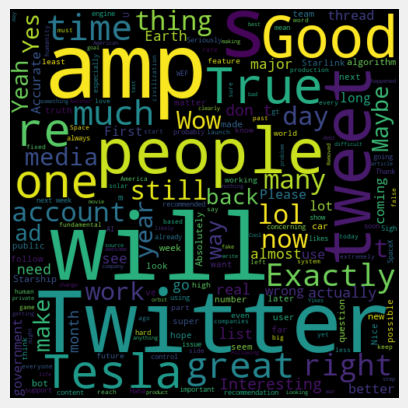

In [18]:
# Creating a word cloud
allWords = ' '.join([twts for twts in df['Tweet']])

wordCloud = WordCloud(width=500,height=500,random_state=21,max_font_size=119,stopwords=STOPWORDS).generate(allWords)
plt.imshow(wordCloud, interpolation = "bilinear")
plt.axis('off')
plt.show()

### Generating word cloud for only Positive Polarity Tweets

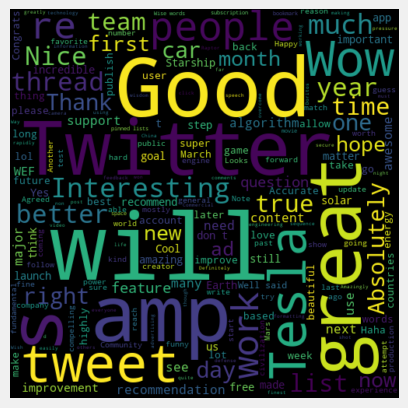

In [19]:
# Creating a word cloud
allWords = ' '.join([twts for twts in df_positive['Tweet']])

wordCloud = WordCloud(width=500,height=500,random_state=21,max_font_size=119,stopwords=STOPWORDS).generate(allWords)
plt.imshow(wordCloud, interpolation = "bilinear")
plt.axis('off')
plt.show()

 ## Generating word cloud for only Neutral Polarity Tweets

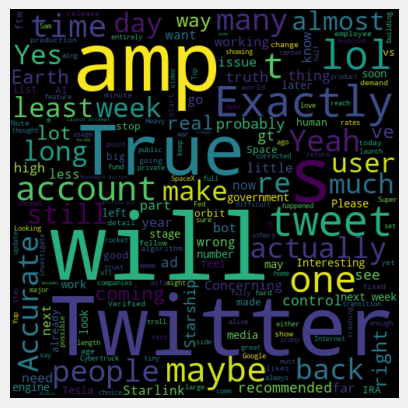

In [20]:
# Creating a word cloud
allWords = ' '.join([twts for twts in df_neutral['Tweet']])

wordCloud = WordCloud(width=500,height=500,random_state=21,max_font_size=119,stopwords=STOPWORDS).generate(allWords)
plt.imshow(wordCloud, interpolation = "bilinear")
plt.axis('off')
plt.show()

## Generating word cloud for only Negative Polarity Tweets

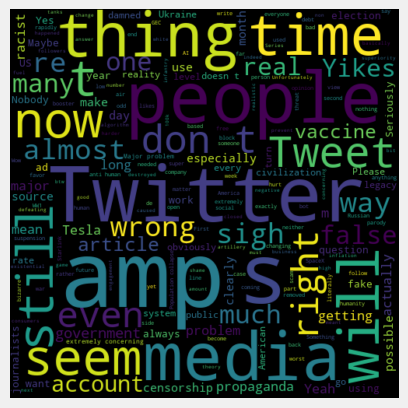

In [21]:
# Creating a word cloud
allWords = ' '.join([twts for twts in df_negative['Tweet']])

wordCloud = WordCloud(width=500,height=500,random_state=21,max_font_size=119,stopwords=STOPWORDS).generate(allWords)
plt.imshow(wordCloud, interpolation = "bilinear")
plt.axis('off')
plt.show()

In [22]:
# Loop over each tweet in the dataframe
for tweet in df['Tweet']:
    # Create a TextBlob object for the tweet
    blob = TextBlob(tweet)
    
    # Perform some basic analysis on the tweet using TextBlob methods
    print('Noun phrases:', blob.noun_phrases)

Noun phrases: []
Noun phrases: ['periodic', 'twitter lists', 'will']
Noun phrases: ['accurate']
Noun phrases: ['yeah']
Noun phrases: ['tesla', 'int8', 'fp16', 'quantization errors']
Noun phrases: ['wow', 'amazingly', 'russian', 'national security missions']
Noun phrases: ['raptor', 'test stand', '’ re', 'start sequence', 'difficult propellant inlet pressures', 'low pressure', 'warm ” liquid oxygen']
Noun phrases: ['kind']
Noun phrases: ['raptor']
Noun phrases: ['looking']
Noun phrases: []
Noun phrases: []
Noun phrases: []
Noun phrases: ['basedai']
Noun phrases: []
Noun phrases: ['absolutely']
Noun phrases: ['large construction projects']
Noun phrases: ['anubis']
Noun phrases: ['air superiority', 'leaves infantry', 'artillery –', 'ww1', 'drones', 'sufficient numbers', 'ww1', 'depth trench war']
Noun phrases: ['ukraine', 'max defense mode']
Noun phrases: []
Noun phrases: ['’ s']
Noun phrases: ['berkshire hathaway', 'coke']
Noun phrases: []
Noun phrases: ['realistic end game']
Noun phrase

Noun phrases: []
Noun phrases: ['’ s']
Noun phrases: ['wide release', 'america', 'eu', '’ ve', 'na', 'ww']
Noun phrases: []
Noun phrases: []
Noun phrases: ['giant block', 'recommendation system', 'ddos']
Noun phrases: ['verified', 'bot/troll manipulation']
Noun phrases: []
Noun phrases: ['anecdotally', 'wasn ’ t']
Noun phrases: ['advertising', '’ s', 'amazingly', 'twitter searches don ’ t', 'search words', '’ re']
Noun phrases: ['oversized', 'week ]']
Noun phrases: ['long day', 'twitter hq', 'eng team', 'significant problems', 'fanout', 'following', 'following', 'earlybird']
Noun phrases: ['well-said']
Noun phrases: ['true']
Noun phrases: []
Noun phrases: ['starship']
Noun phrases: []
Noun phrases: []
Noun phrases: []
Noun phrases: ['extremely']
Noun phrases: ['fundamental reason', 'tesla', 'new american car company', 'positive cash flow', 'chrysler', '~100 years', 'fundamental cost disadvantage']
Noun phrases: ['exactly']
Noun phrases: ['tesla solar roof']
Noun phrases: ['periscope', 

Noun phrases: ['notes']
Noun phrases: []
Noun phrases: ['’ s']
Noun phrases: ['’ s', 'tweet details']
Noun phrases: ['zero ads']
Noun phrases: ['ads', 'twitter']
Noun phrases: []
Noun phrases: ['key researcher', 'twitter', 'feb']
Noun phrases: ['je', 'pluto']
Noun phrases: ['twitter']
Noun phrases: ['was', 'tesla giga berlin']
Noun phrases: ['twitter', 'less', 'twitter']
Noun phrases: ['og c19', 'bad effects', 'arm hurt', 'mrna booster']
Noun phrases: ['peak health', 'serious case']
Noun phrases: []
Noun phrases: ['major side', 'booster shot', 'felt', 'permanent damage']
Noun phrases: ['extremely']
Noun phrases: []
Noun phrases: ['sigh', 'sam', 'old super rational self']
Noun phrases: ['cool']
Noun phrases: ['interesting']
Noun phrases: ['🤣 yeah']
Noun phrases: ['wow']
Noun phrases: ['possible curses']
Noun phrases: ['cool']
Noun phrases: ['george washington', 'old guy ”']
Noun phrases: ['japan', 'total user-minutes', 'usa', 'japan']
Noun phrases: ['’ m', 'possible release']
Noun phras

## Extracting Noun Phrases from Tweets 
This extracts the relevant subject matter in each tweet.

In [23]:
# Loop over each tweet in the dataframe
for tweet in df_positive['Tweet']:
    # Create a TextBlob object for the tweet
    blob = TextBlob(tweet)
    
    # Perform some basic analysis on the tweet using TextBlob methods
    print('Noun phrases:', blob.noun_phrases)

Noun phrases: []
Noun phrases: ['periodic', 'twitter lists', 'will']
Noun phrases: ['tesla', 'int8', 'fp16', 'quantization errors']
Noun phrases: ['wow', 'amazingly', 'russian', 'national security missions']
Noun phrases: ['raptor', 'test stand', '’ re', 'start sequence', 'difficult propellant inlet pressures', 'low pressure', 'warm ” liquid oxygen']
Noun phrases: ['kind']
Noun phrases: ['raptor']
Noun phrases: []
Noun phrases: ['absolutely']
Noun phrases: ['’ s']
Noun phrases: ['accurate']
Noun phrases: []
Noun phrases: ['great work']
Noun phrases: ['haha']
Noun phrases: ['haha']
Noun phrases: ['saylorgpt']
Noun phrases: ['wow']
Noun phrases: ['hope']
Noun phrases: ['wow']
Noun phrases: ['astronaut']
Noun phrases: ['absolutely']
Noun phrases: ['interesting']
Noun phrases: ['nice']
Noun phrases: ['hangover', 'funny tho']
Noun phrases: []
Noun phrases: ['rewatching step']
Noun phrases: ['doritos']
Noun phrases: []
Noun phrases: []
Noun phrases: []
Noun phrases: ['interesting question', 

In [24]:
# Loop over each tweet in the dataframe
for tweet in df_neutral['Tweet']:
    # Create a TextBlob object for the tweet
    blob = TextBlob(tweet)
    
    # Perform some basic analysis on the tweet using TextBlob methods
    print('Noun phrases:', blob.noun_phrases)

Noun phrases: ['accurate']
Noun phrases: ['yeah']
Noun phrases: ['looking']
Noun phrases: []
Noun phrases: []
Noun phrases: ['basedai']
Noun phrases: []
Noun phrases: ['large construction projects']
Noun phrases: ['anubis']
Noun phrases: ['ukraine', 'max defense mode']
Noun phrases: []
Noun phrases: ['berkshire hathaway', 'coke']
Noun phrases: []
Noun phrases: ['high time humanity']
Noun phrases: ['space station', 'real']
Noun phrases: ['stinky wifi', 'fav –', '’ t', '’ s']
Noun phrases: ['changing starlink', 'default wifi name', 'fbi-van', 'april']
Noun phrases: []
Noun phrases: []
Noun phrases: ['earth', '’ d', 'dark ice ball', 'chemotrophic bacteria']
Noun phrases: ['true']
Noun phrases: ['starlink', 'v2 satellites']
Noun phrases: []
Noun phrases: ['propulsive', 'ftw']
Noun phrases: ['don ’ t', 'scott', 'dilbert', 'legit funny']
Noun phrases: []
Noun phrases: ['’ re']
Noun phrases: []
Noun phrases: []
Noun phrases: ['great way']
Noun phrases: []
Noun phrases: ['’ s', 'spacex']
Noun 

Noun phrases: ['forum']
Noun phrases: ['media', 'citizen journalism']
Noun phrases: ['people users didn ’ t']
Noun phrases: ['brief', 'atlanta', 'portland', 'data centers']
Noun phrases: ['interesting']
Noun phrases: ['video implies people']
Noun phrases: ['car aquatic']
Noun phrases: []
Noun phrases: ['twitter verified', 'troll farms']
Noun phrases: []
Noun phrases: ['trashing', 'basically', '* account', '* account', 'wrong lol']
Noun phrases: ['twitter']
Noun phrases: ['bbc', 'british *', 'broadcasting', 'others …']
Noun phrases: ['well', 'banthebbc', '’ s', 'state influence/affiliation', 'twitter/fb/google']
Noun phrases: ['true']
Noun phrases: ['center core', 'falcon', 'stage rocket', 'rapid reusability', 'earth', 'stage rocket', '1st stage returns', 'launch site', 'stage orbits', 'ground track', 'launch site']
Noun phrases: ['wing ” stuff', 'wing ” stuff', 'echo chamber']
Noun phrases: ['exactly', 'heterogeneous databases', 'vast amounts', 'legacy code', 'cobol', 'batch mode']
Nou

In [25]:
# Loop over each tweet in the dataframe
for tweet in df_negative['Tweet']:
    # Create a TextBlob object for the tweet
    blob = TextBlob(tweet)
    
    # Perform some basic analysis on the tweet using TextBlob methods
    print('Noun phrases:', blob.noun_phrases)

Noun phrases: ['air superiority', 'leaves infantry', 'artillery –', 'ww1', 'drones', 'sufficient numbers', 'ww1', 'depth trench war']
Noun phrases: ['realistic end game']
Noun phrases: ['small %']
Noun phrases: []
Noun phrases: ['cm', 'de-orbit burn', 'atmospheric entry control']
Noun phrases: []
Noun phrases: []
Noun phrases: ['ai', 'existential angst']
Noun phrases: ['elite colleges']
Noun phrases: ['false narrative']
Noun phrases: ['long time', 'us media', 'non-white people', '’ re racist', 'asians', 'elite colleges', 'high schools', 'america']
Noun phrases: []
Noun phrases: ['~ $ 100k', 'student debt']
Noun phrases: ['don ’ t']
Noun phrases: []
Noun phrases: ['’ t witchcraft defeat inflation']
Noun phrases: ['algorithm btw 🤣']
Noun phrases: []
Noun phrases: ['yikes']
Noun phrases: ['doesn', '’ t', '’ re']
Noun phrases: ['couldn', '’ t', 'toilet paper 😢']
Noun phrases: ['british …']
Noun phrases: ['anti-human woke mind virus']
Noun phrases: []
Noun phrases: ['kids']
Noun phrases: ['

## Ranking Noun Phrases by Frequency Count

In [26]:
# Define an empty dictionary to store the noun phrase counts
np_counts = {}

# Loop over each tweet in the dataframe
for tweet in df['Tweet']:
    # Create a TextBlob object for the tweet
    blob = TextBlob(tweet)
    
    # Get the noun phrases for the tweet and update the counts in the dictionary
    for np in blob.noun_phrases:
        if np in np_counts:
            np_counts[np] += 1
        else:
            np_counts[np] = 1

# Sort the dictionary by the counts in descending order
ranked_dict = sorted(np_counts.items(), key=lambda x: x[1], reverse=True)

# Print out the noun phrases and their counts
for np, count in ranked_dict:
    if count > 1:
        print(f"{np} repeats {count} times")

twitter repeats 64 times
’ s repeats 52 times
’ re repeats 25 times
true repeats 24 times
wow repeats 20 times
exactly repeats 19 times
tesla repeats 17 times
yeah repeats 14 times
’ t repeats 14 times
earth repeats 14 times
absolutely repeats 11 times
don ’ t repeats 11 times
starship repeats 11 times
will repeats 10 times
interesting repeats 10 times
nice repeats 10 times
accurate repeats 9 times
’ ve repeats 9 times
’ m repeats 9 times
please repeats 9 times
starlink repeats 7 times
spacex repeats 7 times
looking repeats 6 times
haha repeats 6 times
ai repeats 6 times
yikes repeats 6 times
concerning repeats 6 times
following repeats 6 times
wef repeats 6 times
ukraine repeats 5 times
america repeats 5 times
your repeats 5 times
agreed repeats 5 times
seriously repeats 5 times
tweet repeats 5 times
lists repeats 5 times
long time repeats 4 times
cool repeats 4 times
major problem repeats 4 times
fed repeats 4 times
sigh repeats 4 times
cybertruck repeats 4 times
well-said repeats 4 